<img src="http://certificate.tpq.io/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# EPAT Session 2

**Executive Program in Algorithmic Trading**

**_Vectorized Backtesting_**

Prof. Dr. Yves J. Hilpisch | The Python Quants GmbH | http://tpq.io

<a href="https://home.tpq.io/certificates/pyalgo" target="_blank"><img src="https://hilpisch.com/pyalgo_cover_color.png" width="300px" align="left" border="1px"></a>

## Basic Imports

In [1]:
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
pd.set_option('mode.chained_assignment', None)

## Reading Financial Data

In [2]:
url = 'http://hilpisch.com/pyalgo_eikon_eod_data.csv'  # EOD data
# url = 'http://hilpisch.com/aiif_eikon_id_data.csv'  # intraday data

In [3]:
raw = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

In [4]:
rets = np.log(raw / raw.shift(1)).dropna()

## Regime Detection

In [5]:
from sklearn.cluster import KMeans

### Features

In [6]:
symbol = '.SPX'

In [7]:
f = pd.DataFrame()

In [8]:
window = 20

In [13]:
f['mom'] = rets[symbol].rolling(window).mean() * 252  # annualized time series momentum
f['vol'] = rets[symbol].rolling(window).std() * 252 ** 0.5  # annualized volatility

In [14]:
f.dropna(inplace=True)

In [16]:
f = (f - f.mean()) / f.std()  # Gaussian normalization

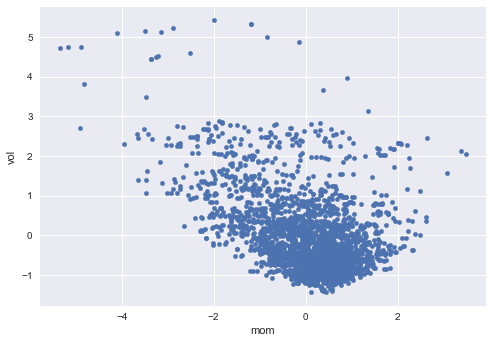

In [17]:
f.plot.scatter(x='mom', y='vol');

### Clustering

In [13]:
model = KMeans(n_clusters=4)  # 1. model instantiation

In [14]:
model.fit(f)  # 2. model fitting

KMeans(n_clusters=4)

In [15]:
p = model.predict(f)  # 3. prediction based on fitted model

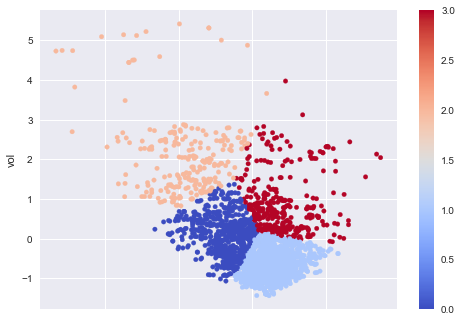

In [16]:
f.plot.scatter(x='mom', y='vol', c=p, cmap='coolwarm');

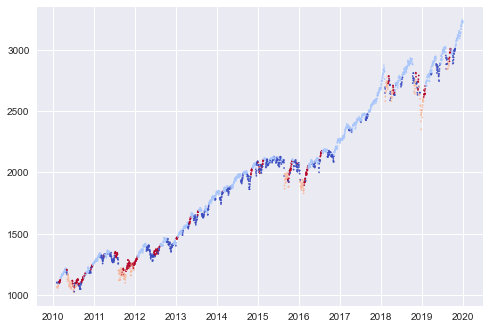

In [17]:
plt.scatter(x=raw.index[window:], y=raw['.SPX'][window:],
            c=p, cmap='coolwarm', marker='.', s=7.5);

## Advanced Trading Strategy

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [19]:
symbol = 'EUR='

In [20]:
data = pd.DataFrame(raw[symbol])

### Data Preprocessing

In [21]:
data['r'] = np.log(data / data.shift(1))

In [22]:
lags = 5

In [23]:
cols = list()
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = np.sign(data['r']).shift(lag)
    cols.append(col)

In [24]:
cols

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

In [25]:
data['d'] = np.sign(data['r'])

In [26]:
data.head(8)

,EUR=,r,lag_1,lag_2,lag_3,lag_4,lag_5,d
Date,,,,,,,,
2010-01-04,1.4411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.4368,-0.002988,NaN,NaN,NaN,NaN,NaN,-1.0
2010-01-06,1.4412,0.003058,-1.0,NaN,NaN,NaN,NaN,1.0
2010-01-07,1.4318,-0.006544,1.0,-1.0,NaN,NaN,NaN,-1.0
2010-01-08,1.4412,0.006544,-1.0,1.0,-1.0,NaN,NaN,1.0
2010-01-11,1.4513,0.006984,1.0,-1.0,1.0,-1.0,NaN,1.0
2010-01-12,1.4494,-0.001310,1.0,1.0,-1.0,1.0,-1.0,-1.0
2010-01-13,1.4510,0.001103,-1.0,1.0,1.0,-1.0,1.0,1.0


In [27]:
data.dropna(inplace=True)

### Model Fitting (In-Sample)

In [28]:
model = GaussianNB()

In [29]:
# MLPClassifier?

In [30]:
model = MLPClassifier(hidden_layer_sizes=[48, 48],
                      shuffle=False,
                      random_state=100) # 1. step

In [31]:
model.fit(data[cols], data['d'])  # 2. step

MLPClassifier(hidden_layer_sizes=[48, 48], random_state=100, shuffle=False)

In [32]:
data['p'] = model.predict(data[cols])  # 3. step

In [33]:
accuracy_score(data['d'], data['p'])

0.549800796812749

In [34]:
data.head()

,EUR=,r,lag_1,lag_2,lag_3,lag_4,lag_5,d,p
Date,,,,,,,,,
2010-01-12,1.4494,-0.001310,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
2010-01-13,1.4510,0.001103,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0
2010-01-14,1.4502,-0.000551,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0
2010-01-15,1.4382,-0.008309,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0
2010-01-19,1.4298,-0.005858,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0


In [35]:
sum(data['p'].diff() != 0)

1130

### Vectorized Backtesting (In-Sample)

In [36]:
data['s'] = data['p'] * data['r']

In [37]:
data[['r', 's']].sum().apply(np.exp)  # gross performance

r    0.772411
s    2.850902
dtype: float64

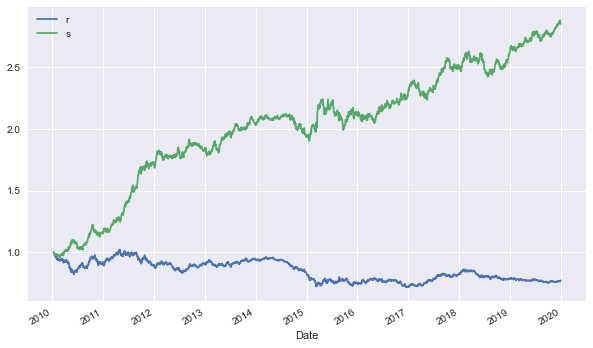

In [38]:
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));  # gross performance over time

### Train-Test Split

In [39]:
split = int(len(data) * 0.8)
split

2008

In [40]:
train = data.iloc[:split].copy()

In [41]:
test = data.iloc[split:].copy()

### Training (In-Sample)

In [42]:
model.fit(train[cols], train['d'])

MLPClassifier(hidden_layer_sizes=[48, 48], random_state=100, shuffle=False)

In [43]:
accuracy_score(train['d'], model.predict(train[cols]))

0.5368525896414342

### Testing (Out-of-Sample)

In [44]:
test['p'] = model.predict(test[cols])

In [45]:
test['s'] = test['p'] * test['r']

In [46]:
test[['r', 's']].sum().apply(np.exp)  # gross performance

r    0.929750
s    1.043089
dtype: float64

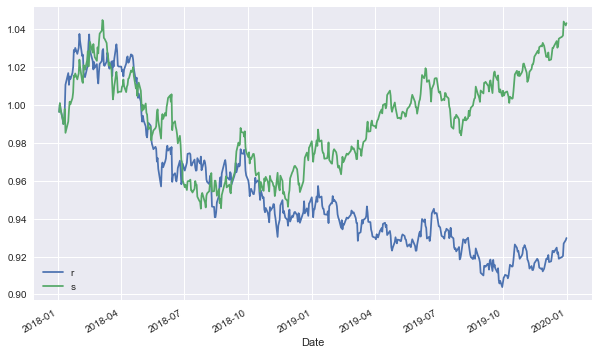

In [47]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));  # gross performance over time

<img src="http://certificate.tpq.io/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>